## 先前配置

In [1]:
# Check for GPU
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
import torch
print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"

2.2.2


## 載入 torchvision.datasets.MNIST() 訓練和測試數據集

In [3]:
import torchvision
from torchvision import datasets
from torchvision import transforms

# 訓練集
train_data = datasets.MNIST(root=".",
                            train=True,
                            download=True,
                            transform=transforms.ToTensor()) 

# 測試集
test_data = datasets.MNIST(root=".",
                           train=False,
                           download=True,
                           transform=transforms.ToTensor()) 

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100%|██████████| 9912422/9912422 [00:05<00:00, 1765914.74it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 139822.88it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:51<00:00, 32316.16it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10513536.85it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
"""確認及檢查資料"""
len(train_data), len(test_data)

(60000, 10000)

In [5]:
"""資料分類層"""
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


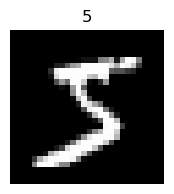

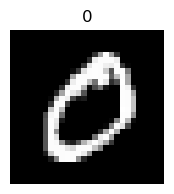

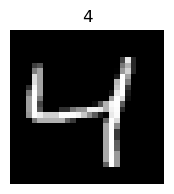

In [14]:
"""畫出三個"""
import matplotlib.pyplot as plt
for i in range(3):
  img, label = train_data[i] # 資料、結果
  print(img.shape)
  img_squeeze = img.squeeze()
  # print(img_squeeze.shape)
  # label = train_data[i][1]
  plt.figure(figsize=(2, 2))
  plt.imshow(img_squeeze, cmap="gray")
  plt.title(label)
  plt.axis(False)

## 將 MNIST 訓練和測試資料集轉換為資料載入器

In [13]:
""" 建立 DataLoader """
from torch.utils.data import DataLoader
# 訓練DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)
# 測試DataLoader
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x16c5c4490>,
 <torch.utils.data.dataloader.DataLoader at 0x16c453950>)

In [19]:
# 檢查資料再放進DataLoader還是沒改變
sample = next(iter(train_dataloader))
img, label = sample
print(img.shape)
  

torch.Size([32, 1, 28, 28])


## 創建 model
解說及教學文章：https://poloclub.github.io/cnn-explainer/

In [35]:
"""
模型製作為：
input = 1
hidden layer = 10
output_shape = 10
"""
  
from torch import nn 
class MNIST_model(torch.nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int): 
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # 卷基層
        nn.Conv2d(in_channels=input_shape, 
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
        # 啟動函數
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
        nn.ReLU(),
        # 池化層 
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)                   
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*7*7, # 自行計算
                out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv block 1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output shape of conv block 2: {x.shape}")
    x = self.classifier(x)
    # print(f"Output shape of classifier: {x.shape}")
    return x

In [36]:
model = MNIST_model(input_shape=1,
                    hidden_units=10,
                    output_shape=10).to(device)
# model

計算最後classifier的in_feature

In [37]:
dummy_x = torch.rand(size=(1, 28, 28)).unsqueeze(dim=0).to(device)
dummy_x.shape
model(dummy_x)

tensor([[ 0.0011, -0.0103,  0.0007, -0.0470,  0.0179,  0.0539, -0.0706,  0.0677,
         -0.0567,  0.0270]], grad_fn=<AddmmBackward0>)

## 跑訓練模型

In [39]:
"""計算準確率"""
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [42]:
from tqdm.auto import tqdm
torch.manual_seed(42)

# 建立一個MNIST模型實例，輸入維度為1，隱藏層單元數為10，輸出維度為10，並將模型移動到CPU上
model_cpu = MNIST_model(input_shape=1,
                        hidden_units=10,
                        output_shape=10).to("cpu")

# 定義損失函數為交叉熵損失函數
loss_fn = nn.CrossEntropyLoss()
# 定義優化器為隨機梯度下降(SGD)，學習率為0.1
optimizer = torch.optim.SGD(model_cpu.parameters(), lr=0.1)

### 訓練迴圈
epochs = 5
for epoch in tqdm(range(epochs)):
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        # 將模型設置為訓練模式
        model_cpu.train()
        # 前向傳播，取得預測值
        y_pred = model_cpu(X)
        # 計算損失函數
        loss = loss_fn(y_pred, y)
        train_loss += loss
        # 優化器梯度歸零
        optimizer.zero_grad()
        # 反向傳播
        loss.backward()
        # 更新模型參數
        optimizer.step()
    # 調整訓練損失值，使其為所有批次的平均值
    train_loss /= len(train_dataloader)

    ### 測試迴圈
    test_loss_total = 0
    test_acc_total = 0
    # 將模型設置為評估模式
    model_cpu.eval()
    # 啟用推理模式
    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(test_dataloader):
            # 確保測試數據在CPU上
            X_test, y_test = X_test.to("cpu"), y_test.to("cpu")
            test_pred = model_cpu(X_test)
            test_loss = loss_fn(test_pred, y_test)
            test_loss_total += test_loss

            # 獲取預測類別
            _, y_pred = torch.max(test_pred.data, 1)

            # 計算準確率
            test_acc_total += accuracy_fn(y_true=y_test, y_pred=y_pred)

        # 計算平均測試損失
        test_loss_total /= len(test_dataloader)
        test_acc_total /= len(test_dataloader)

    print(f"Epoch: {epoch} | Loss: {train_loss:.3f} | Test loss: {test_loss_total:.3f} | Test acc: {test_acc_total:.2f}%\n")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Loss: 0.266 | Test loss: 0.076 | Test acc: 97.49%

Epoch: 1 | Loss: 0.069 | Test loss: 0.043 | Test acc: 98.56%

Epoch: 2 | Loss: 0.054 | Test loss: 0.043 | Test acc: 98.60%

Epoch: 3 | Loss: 0.044 | Test loss: 0.045 | Test acc: 98.56%

Epoch: 4 | Loss: 0.040 | Test loss: 0.035 | Test acc: 98.89%



## 使用模型進行預測

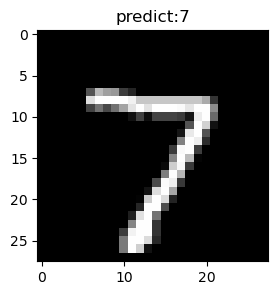

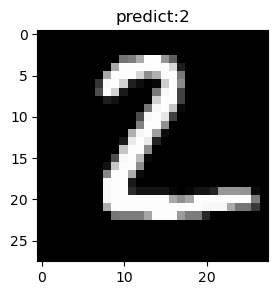

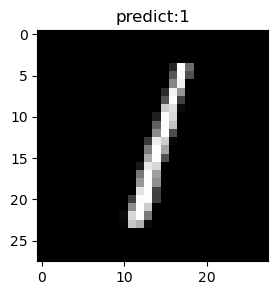

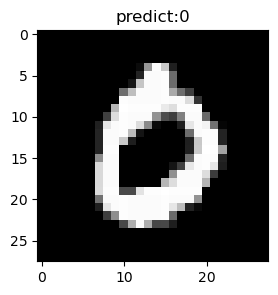

In [60]:
# Logits -> Prediction probabilities -> Prediction labels
import matplotlib.pyplot as plt

for i in range(4):
    # 從測試資料中取得第i個影像和標籤
    img, label = test_data[i]
    
    # 將影像加入批次維度並移動到設備上
    # 進行前向傳播以獲取模型預測的logits(未經過softmax的原始輸出值)
    model_pred_logits = model_cpu(img.unsqueeze(dim=0).to(device))
    # 將logits輸入softmax函數以獲取預測機率
    model_pred_probs = torch.softmax(model_pred_logits, dim=1)
    # 從預測機率中取得最大值作為預測標籤
    model_pred_label = torch.argmax(model_pred_probs, dim=1)
    # 建立一個3x3的繪圖區域
    plt.figure(figsize=(3, 3))
    # 繪製影像,使用灰階色彩對映
    plt.imshow(img.squeeze(), cmap="gray")
    # 設置標題為預測標籤
    plt.title(f"predict:{model_pred_label.item()}")
    # 顯示座標軸
    plt.axis(True)

# lab14 加分題

In [103]:
import torchvision
from torchvision import datasets
from torchvision import transforms

# 定義轉換器
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale()  # 將影像轉換為灰階
])

# 訓練集
train_data = datasets.CIFAR10(root=".",
                            train=True,
                            download=True,
                            transform=transform) 

# 測試集
test_data = datasets.CIFAR10(root=".",
                           train=False,
                           download=True,
                           transform=transform) 

100%|██████████| 170498071/170498071 [00:32<00:00, 5288532.96it/s] 


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [102]:
"""確認及檢查資料"""
len(train_data), len(test_data)

(50000, 10000)

In [64]:
"""資料分類層"""
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

torch.Size([1, 32, 32]) frog


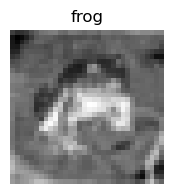

torch.Size([1, 32, 32]) truck


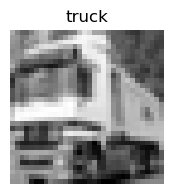

torch.Size([1, 32, 32]) truck


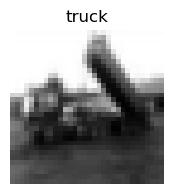

In [104]:
"""畫出三個"""
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# 定義轉換器,將影像轉換為灰階
to_grayscale = transforms.Grayscale()

for i in range(3):
    img, label = train_data[i]  # 資料、結果
    print(img.shape, class_names[label])

    # 將影像轉換為灰階
    img = to_grayscale(img)
    # print(img.shape)

    # 移除批次維度
    img_squeeze = img.squeeze()
    # print(img_squeeze.shape)

    plt.figure(figsize=(2, 2))
    plt.imshow(img_squeeze, cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)
    plt.show()

In [105]:
""" 建立 DataLoader """
from torch.utils.data import DataLoader
# 訓練DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)
# 測試DataLoader
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x17b846ed0>,
 <torch.utils.data.dataloader.DataLoader at 0x17bb13790>)

In [116]:
"""
模型製作為：
input = 1
hidden layer = 10
output_shape = 10
"""

from torch import nn 
class CIFAR10_model(torch.nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int): 
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        # 卷基層
        nn.Conv2d(in_channels=input_shape, 
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
        # 啟動函數
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
        nn.ReLU(),
        # 池化層 
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)                   
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*8*8, # 自行計算
                out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv block 1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output shape of conv block 2: {x.shape}")
    x = self.classifier(x)
    # print(f"Output shape of classifier: {x.shape}")
    return x

In [117]:
model = CIFAR10_model(input_shape=1,
                    hidden_units=10,
                    output_shape=len(class_names)).to(device)
# model

In [118]:
dummy_x = torch.rand(size=(1, 32, 32)).unsqueeze(dim=0).to(device)
dummy_x.shape
model(dummy_x)

tensor([[ 0.0007, -0.0248,  0.0230, -0.0294,  0.0152,  0.0137, -0.0577, -0.0058,
          0.0306, -0.0518]], grad_fn=<AddmmBackward0>)

In [119]:
"""計算準確率"""
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [120]:
from tqdm.auto import tqdm
torch.manual_seed(42)

# 建立一個MNIST模型實例，輸入維度為1，隱藏層單元數為10，輸出維度為10，並將模型移動到CPU上
model_cpu = CIFAR10_model(input_shape=1,
                        hidden_units=10,
                        output_shape=len(class_names)).to("cpu")

# 定義損失函數為交叉熵損失函數
loss_fn = nn.CrossEntropyLoss()
# 定義優化器為隨機梯度下降(SGD)，學習率為0.1
optimizer = torch.optim.SGD(model_cpu.parameters(), lr=0.1)

### 訓練迴圈
epochs = 5
for epoch in tqdm(range(epochs)):
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        # 將模型設置為訓練模式
        model_cpu.train()
        # 前向傳播，取得預測值
        y_pred = model_cpu(X)
        # 計算損失函數
        loss = loss_fn(y_pred, y)
        train_loss += loss
        # 優化器梯度歸零
        optimizer.zero_grad()
        # 反向傳播
        loss.backward()
        # 更新模型參數
        optimizer.step()
    # 調整訓練損失值，使其為所有批次的平均值
    train_loss /= len(train_dataloader)

    ### 測試迴圈
    test_loss_total = 0
    test_acc_total = 0
    # 將模型設置為評估模式
    model_cpu.eval()
    # 啟用推理模式
    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(test_dataloader):
            # 確保測試數據在CPU上
            X_test, y_test = X_test.to("cpu"), y_test.to("cpu")
            test_pred = model_cpu(X_test)
            test_loss = loss_fn(test_pred, y_test)
            test_loss_total += test_loss

            # 獲取預測類別
            _, y_pred = torch.max(test_pred.data, 1)

            # 計算準確率
            test_acc_total += accuracy_fn(y_true=y_test, y_pred=y_pred)

        # 計算平均測試損失
        test_loss_total /= len(test_dataloader)
        test_acc_total /= len(test_dataloader)

    print(f"Epoch: {epoch} | Loss: {train_loss:.3f} | Test loss: {test_loss_total:.3f} | Test acc: {test_acc_total:.2f}%\n")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Loss: 1.948 | Test loss: 1.707 | Test acc: 40.05%

Epoch: 1 | Loss: 1.525 | Test loss: 1.447 | Test acc: 48.89%

Epoch: 2 | Loss: 1.367 | Test loss: 1.513 | Test acc: 47.22%

Epoch: 3 | Loss: 1.288 | Test loss: 1.286 | Test acc: 55.15%

Epoch: 4 | Loss: 1.249 | Test loss: 1.288 | Test acc: 54.75%



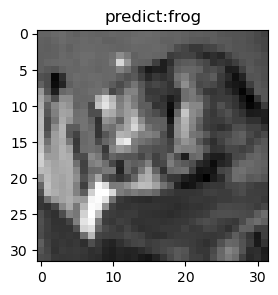

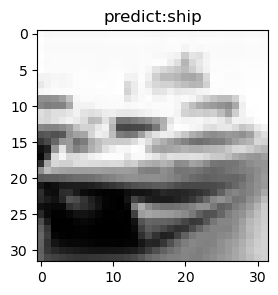

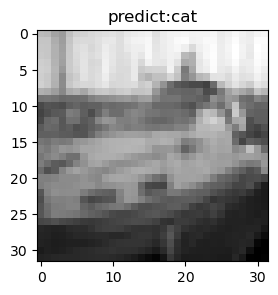

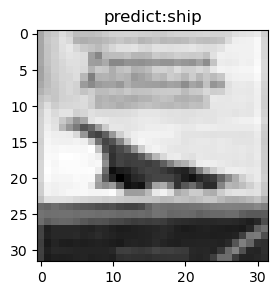

In [122]:
# Logits -> Prediction probabilities -> Prediction labels
import matplotlib.pyplot as plt

for i in range(4):
    # 從測試資料中取得第i個影像和標籤
    img, label = test_data[i]
    
    # 將影像加入批次維度並移動到設備上
    # 進行前向傳播以獲取模型預測的logits(未經過softmax的原始輸出值)
    model_pred_logits = model_cpu(img.unsqueeze(dim=0).to(device))
    # 將logits輸入softmax函數以獲取預測機率
    model_pred_probs = torch.softmax(model_pred_logits, dim=1)
    # 從預測機率中取得最大值作為預測標籤
    model_pred_label = torch.argmax(model_pred_probs, dim=1)
    # 建立一個3x3的繪圖區域
    plt.figure(figsize=(3, 3))
    # 繪製影像,使用灰階色彩對映
    plt.imshow(img.squeeze(), cmap="gray")
    # 設置標題為預測標籤
    plt.title(f"predict:{class_names[model_pred_label.item()]}")
    # 顯示座標軸
    plt.axis(True)